# dogs vs. cats project

## 项目背景
---
本项目是Kaggle上的一个已经结束的比赛项目。
* 数据源：kaggle dogs-vs-cats项目公共数据集
下载地址：https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data
* 目标：使用三个模型：Xception，InceptionResNetV2，DenseNet201进行融合，对融合后的模型fine-tune后对test数据集进行预测，并达到项目规定的要求.
* 要求：kaggle Public Leaderboard 前10%，根据https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/leaderboard ，10%位置的score大约为0.06149.

In [ ]:
# 下载项目公共数据集
# 若已下载并完成解压缩，可不必运行此代码
'''
!wget -c "https://storage.googleapis.com/kaggle-competitions-data/kaggle/5441/train.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1531099741&Signature=QrHknOhnGgAMTE2SocAeXjtvDtMydHT6aQg1uKm%2BTRP%2FpahTNd%2BsFiLWQt5kWzcatAlTqcue9NMt0vEfvEQxe1YxTJw2zEc2k7xCS7ov6Fx4Svy4phRqGAShCqRlnPXDGFuYFR5%2BMkDfRtBD9ccD9mq0%2BOmnJ9t%2Bu5cjDYCuhgOkS%2Bjr671jn7qlLBGaRdQrqiJuI453AP%2FfbVA9nlol1RZr33xXtH2Oc08lYP0aePf8h%2F8TkeSA8Qjcd%2FhVq9hMEC2uNSNFwqLsSfCGsq8wQCc5VNrnrkg1MoJbqmaP2hbbsTHqzU2p026Wxkrxmzmh9lcI62sPv49md%2FsDdnC5qA%3D%3D" -O train.zip
!wget -c "https://storage.googleapis.com/kaggle-competitions-data/kaggle/5441/test.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1531099798&Signature=jq%2BaIEeVIfpHwGTFJzpRG5I%2BzAVnbfxBEwyFXlVkFdwv0tY%2B%2FOB0XhYVpcR9zJghGeQZdVl58SfnW9q856Obp45b4g9QDUTwy0QJ8zFtOAyp6%2BH98xKmuN22wl303sp5dyBibkymWCoJRcFTuEgLREsxoGhCubmdL8rS4kpIn8lgIBoG44fHLBbp9MqNQbS%2BnHnB7dnNxwOWVwJaa4Ysj4ev%2BBs9mtAmrhwVIl14rb%2B8unJO7j0D68MoCqhYP83wMNiSikv1YwStf2KZP8Nvra3BL0gYxRClj9Uc2JllJqLabS7ic%2B49Z7kQxrV%2BGfTjbwvog237jHBbhu7UthHv2g%3D%3D" -O test.zip
!wget -c "https://storage.googleapis.com/kaggle-competitions-data/kaggle/5441/sample_submission.csv?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1531099873&Signature=jRQ04W29p3XJyl5b3o7dNG6KWMCJFbd7gEBqKHBvDBMt3Bml5yDPspr4NJbOxoGo7APufzvISi8IO9rSJktWR5cM%2Ba5wyEt3PwR6HDlxL3jakGI%2FWveCVSJX2KcO7LmLZlBZFLMGFEsg%2BPwzBLlXdrI%2BhBFKUnTV4RgehjVLBzx55ARgeVTJuuqZnU4PoaRGHttx1nmbGYWCviI8LVEexUvJtg2GLwtfcc81piPz1eA1VXUuEaWw8tW7eI6CUJaV39U5IQJrMga63zAy8vRMewNw0Mpn3RszV%2F9pCO1oeIYNP4BGWPkU4d7GoD0Yy6mFdZMRunrrqPqJFnoj6Guejw%3D%3D" -O DATASET/submission/sample_submission.csv



# 对数据集解压缩

!unzip train.zip -d DATASET/
!unzip test.zip -d DATASET/

'''

## 数据准备
---
* 定义train, test，submission文件夹，并下载数据集，train,test解压缩至相应的文件夹

In [2]:
import os
import re
import random
import math
import shutil
from keras.preprocessing import image
import numpy as np
from tqdm import tqdm
import pandas as pd
from keras.applications import xception
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input, decode_predictions

from keras.applications import inception_resnet_v2
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input, decode_predictions

from keras.applications import densenet
from keras.applications.densenet import DenseNet201
from keras.applications.densenet import preprocess_input, decode_predictions

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Lambda
from keras.layers import Activation, Dropout, Flatten, Dense, Input, Dropout, BatchNormalization
from keras import backend as K
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import csv
import cv2
import h5py
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


* 定义文件夹并生成相应的目录

In [3]:
# 初始化数据集相关的所有的文件夹，包含生成的结果集
'''
数据集文件夹结构：
DATASET/
        train/
                dogs/
                cats/
         test/
                pics/
    exception/
   submission/
        
        
'''
# 定义随机数种子，使得每次生成的随机数相同
np.random.seed(1024)

# 定义文件夹
DATASET = "DATASET"
train_dir = DATASET + '/' + 'train'
test_dir = DATASET + '/' + 'test'
submission_dir = DATASET + '/' + 'submission'
exception_dir = DATASET + '/' + 'exception'

def check_folders(dataset_dir, train_dir, test_dir, submis_dir, exception_dir):
    if not os.path.exists(dataset_dir):
        os.makedirs(dataset_dir)
        print("dataset folder is created successfully...")
    else:
        print("dataset folder already created, please check!")
        
    if not os.path.exists(dataset_dir + "/" + train_dir):
        os.makedirs(dataset_dir + "/" + train_dir)
        print("train folder is created successfully...")
    else:
        print("train folder already created, please check!")    
    
    if not os.path.exists(dataset_dir + "/" + test_dir):
        os.makedirs(dataset_dir + "/" + test_dir)
        print("test folder is created successfully...")
    else:
        print("test folder already created, please check!")
        
    if not os.path.exists(dataset_dir + "/" + submis_dir):
        os.makedirs(dataset_dir + "/" + submis_dir)
        print("submission folder is created successfully...")
    else:
        print("submission folder already created, please check!")    
    
    if not os.path.exists(dataset_dir + "/"+ exception_dir):
        os.makedirs(dataset_dir + "/"+ exception_dir)
        print("exception folder is created successfully...")
    else:
        print("exception folder already created, please check!")

check_folders('DATASET', 'train', 'test', 'submission', 'exception')


dataset folder already created, please check!
train folder already created, please check!
test folder already created, please check!
submission folder already created, please check!
exception folder already created, please check!


* 整理ImageNet关于图片的分类数据集，下载地址：https://github.com/zxhx/ImageNetClasses/blob/master/ImageNetClasses.csv
* 读取ImageNetClasses.csv文件并存入字典，以备后面使用

In [4]:
# 下载好的文件"ImageNetFullClasses.csv"位于DATASET目录下，需要将其转换为字典格式存储起来
classes_file_path = "DATASET/ImageNetFullClasses.csv"
ImageNet_full_classes_dict = {}
with open(classes_file_path, "r", encoding='UTF-8') as csv_reader:
    reader = csv.reader(csv_reader)
    for r in reader:
        i_key = r[0]
        i_value = r[1]
        ImageNet_full_classes_dict[i_key] = i_value
#print(ImageNet_full_classes_dict)

## 图片集探索
---
* 确认图片集中train与test中的图片数量并随机查看10张图片

In [5]:
# 图片尺寸
img_size = (299,299)
img_size2 = (224,224)
img_shape = (img_size[0], img_size[1], 3)
img_shape2 = (img_size2[0], img_size2[1], 3)
train_path = "DATASET/train" 
#train_path = "train" 
test_path = "DATASET/test"
# 获取指定路径文件名称，返回一个文件名列表
def get_file_names(path):
    files = os.listdir(path)
    return files

# 根据图片路径以及尺寸获取图片数据
def read_img(fp, img_shape):
    img = image.load_img(fp, target_size = img_shape)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return(x)

# 获取所有图片的预处理输出，并显示进度
def get_img(file_list, img_shape):    
    return [read_img(i, img_shape) for i in tqdm(file_list)]

file_list = [train_path + "/" + i for i in get_file_names(train_path)]
file_list = [i for i in file_list if os.path.isfile(i)]
test_list = [test_path + "/" + i for i in get_file_names(test_path)]
test_list = [i for i in test_list if os.path.isfile(i)]

# 对file_list按路径中的数字排序
## 定义正则
re_digits = re.compile(r'(\d+)')
## 定义排序函数
def sorted_numbers(s):  
    pieces=re_digits.split(s)  
    pieces[1::2]=map(int,pieces[1::2])      
    return pieces  

def sort_list_with_numbers(alist):  
    return sorted(alist, key=sorted_numbers)

file_list = sort_list_with_numbers(file_list)
# print(get_img(file_list, img_shape))

# 按图片的详细路径列表显示图片
def display_pics(show_list, expand_list=None, figsize=(16,8), row=5, pics_num=10,resize_flag=True,simple_title=False):
    plt.figure(figsize=figsize)
    for i in range(len(show_list)):
        plt.subplot(math.ceil(pics_num/row),row,i+1)
        img = mpimg.imread(show_list[i])
        if resize_flag:
            img = cv2.resize(img, (224, 224))
        plt.axis("on")
        if not simple_title:
            plt.title(show_list[i])
        else:
            plt.title(re.findall(r"(\d+\.jpg)",show_list[i])[0]+',  acc = '+str(expand_list[i][0]))
        plt.imshow(img)
# print(file_list)

In [6]:
# 确认train和test图片集中文件数量
print("train图片集中图片数量：{}，test图片集中图片数量：{}".format(len(file_list), len(test_list)))

train图片集中图片数量：25000，test图片集中图片数量：12500


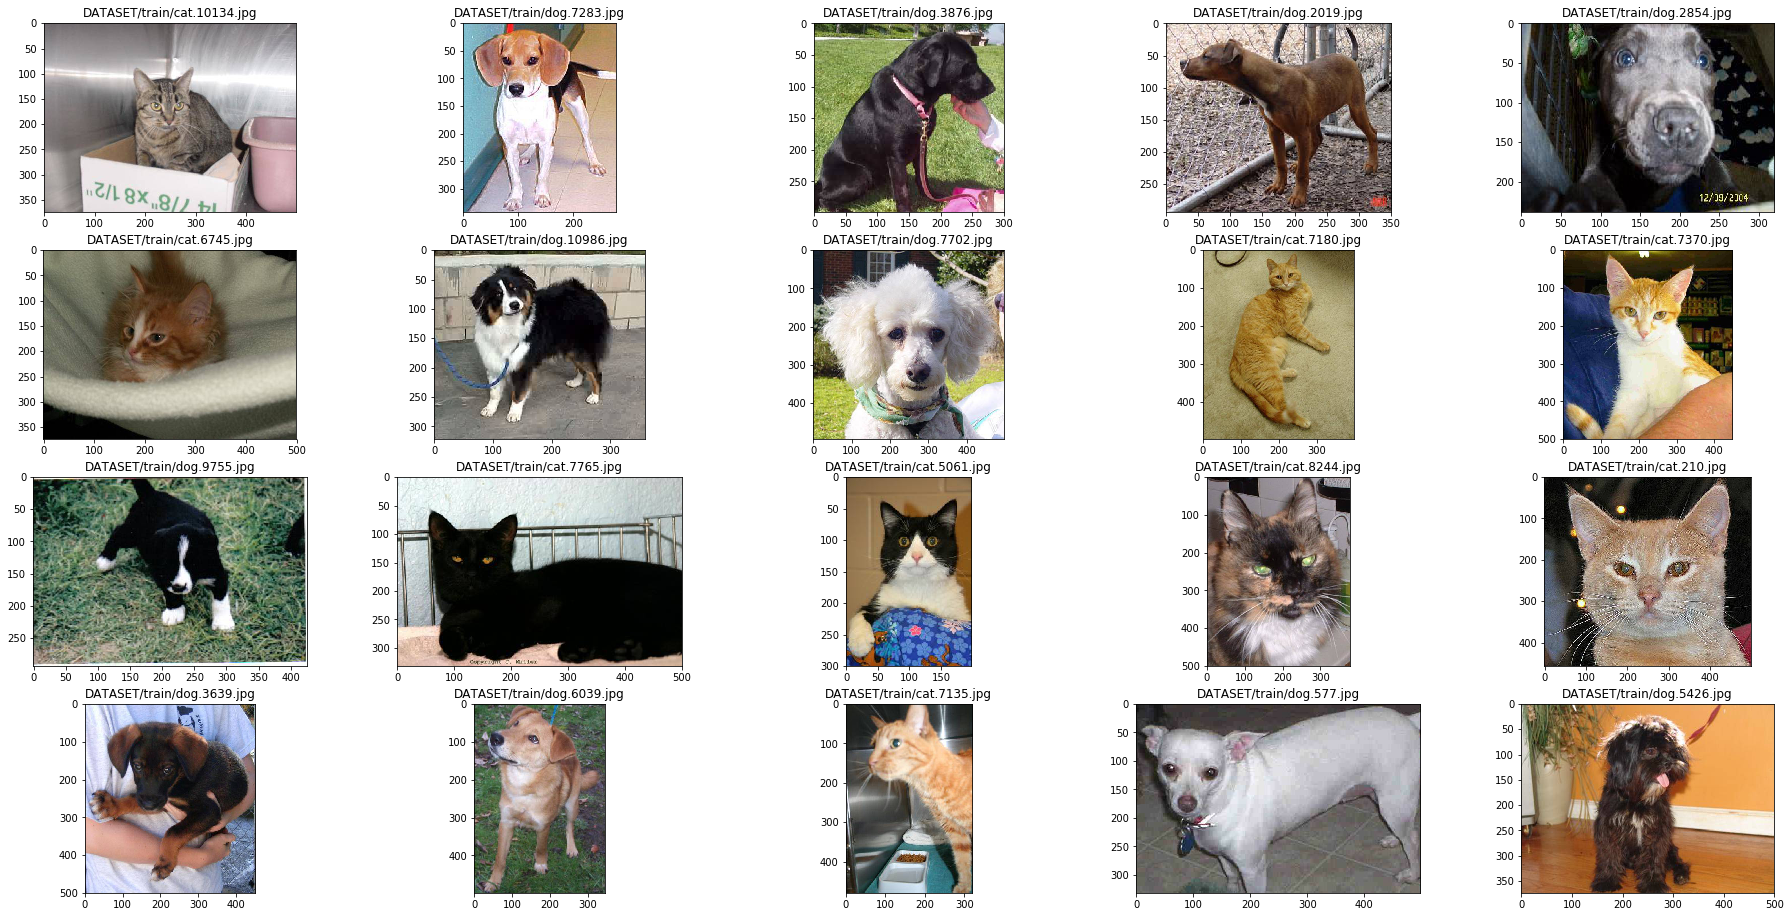

In [7]:
# 随机查看train中的20张图片
file_list_sample = random.sample(file_list, 20)
#test_list_sample = random.sample(test_list, 10)
show_list = file_list_sample
#show_list.extend(test_list_sample)

display_pics(show_list, figsize=(32,16), pics_num=20, resize_flag=False)


In [8]:
# 查看train文件夹中cat的数量和dog的数量
cat_list_all = []
dog_list_all = []
for i in file_list:
    match_cat = re.findall(r'\bcat\.', i)
    match_dog = re.findall(r'\bdog\.', i)
    if match_cat:
        cat_list_all.append(i)
    elif match_dog:
        dog_list_all.append(i)
        
print("train总图片数：{}, 其中猫的数量：{},狗的数量：{}".format(len(cat_list_all)+len(dog_list_all), len(cat_list_all), len(dog_list_all)))

train总图片数：25000, 其中猫的数量：12500,狗的数量：12500


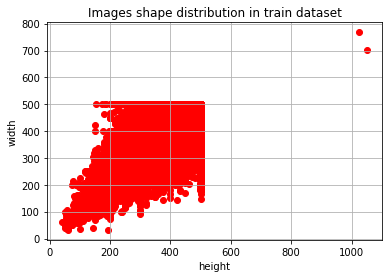

In [9]:
# 查看图片整体的尺寸分布情况
# 绘制尺寸分布的散点图
from PIL import Image
img_x = []
img_y = []
for pic in file_list:
    img = Image.open(pic)
    img_x.append(img.size[0])
    img_y.append(img.size[1])
# print(img_x,img_y)
plt.scatter(img_x,img_y,marker='o',c='r')
plt.grid(True)
plt.title('Images shape distribution in train dataset')
plt.xlabel('height')
plt.ylabel('width')
plt.show()    


In [10]:
# 获取猫和狗的具体类别,输入：字典dic,主要是前面已经获取到的ImageNet_full_classes_dict，输出：只含猫和狗的具体类别code列表
def get_classes(dic):
    cat_dog_classes_code = []
    if dic:
        for k in dic:
            if dic[k] == "猫" or dic[k] == "狗":
                cat_dog_classes_code.append(k)
    else:
        print("ImageNet_full_classes_dict is empty, please check!")
    return cat_dog_classes_code
# print(ImageNet_full_classes_dict)
valid_classes = get_classes(ImageNet_full_classes_dict)
print(valid_classes)


['n02085620', 'n02085782', 'n02085936', 'n02086079', 'n02086240', 'n02086646', 'n02086910', 'n02087046', 'n02087394', 'n02088094', 'n02088238', 'n02088364', 'n02088466', 'n02088632', 'n02089078', 'n02089867', 'n02089973', 'n02090379', 'n02090622', 'n02090721', 'n02091032', 'n02091134', 'n02091244', 'n02091467', 'n02091635', 'n02091831', 'n02092002', 'n02092339', 'n02093256', 'n02093428', 'n02093647', 'n02093754', 'n02093859', 'n02093991', 'n02094114', 'n02094258', 'n02094433', 'n02095314', 'n02095570', 'n02095889', 'n02096051', 'n02096177', 'n02096294', 'n02096437', 'n02096585', 'n02097047', 'n02097130', 'n02097209', 'n02097298', 'n02097474', 'n02097658', 'n02098105', 'n02098286', 'n02098413', 'n02099267', 'n02099429', 'n02099601', 'n02099712', 'n02099849', 'n02100236', 'n02100583', 'n02100735', 'n02100877', 'n02101006', 'n02101388', 'n02101556', 'n02102040', 'n02102177', 'n02102318', 'n02102480', 'n02102973', 'n02104029', 'n02104365', 'n02105056', 'n02105162', 'n02105251', 'n02105412'

# 清除异常图片：判断异常图片
---
* 主要的可能：非猫非狗、猫狗图像过小或过于模糊感觉无法判断的
* 清除前先显示出来，可以先人工检查并确认一遍，尽量避免误判导致的将有用的特征图片删掉了
* 异常图片转移到'DATASET/exception'文件夹中

In [11]:
# 获取预测结果
def get_preds(model, X, top = 40):
    results = []
    model = model
    for x in tqdm(X):
        pred = model.predict(x)
        pred_decode = decode_predictions(pred, top = top)[0]
        results.append(pred_decode)
    return results

# 使用keras中的预训练模型Xception作为非猫非狗异常图片的筛选器
X = get_img(file_list, img_shape)
X2 = get_img(file_list, img_shape2)

100%|██████████| 25000/25000 [02:28<00:00, 168.77it/s]


In [12]:
# model: Xception
model_xception = Xception(weights='imagenet')


In [13]:
# model: DenseNet201
model_DenseNet201 = DenseNet201(weights='imagenet')


In [14]:
# model: InceptionResNetV2
model_InceptionResNetV2 = InceptionResNetV2(weights='imagenet')


In [15]:
# 定义函数:找出非猫非狗的图片，返回except_index，格式：[0, 0, 1, 1, 1]，假设有5张图片，0表示正常，1表示异常
def get_except_index(preds):
    except_index = []
    right_index = []
    right_list_num = []
    for pred in preds:
        right_list_num = [item[0] for item in pred]
        right_list_num = [1 for item in right_list_num if item in valid_classes]
        right_index.append(sum(right_list_num))
    for i in right_index:
        if i == 0:
            except_index.append(1)
        else:
            except_index.append(0)
    return except_index


In [16]:
def exception_info(model, top = 40, shape=img_shape):
    shape_224 = (224,224,3)
    if list(shape)==list(shape_224):
        inpt = X2
    else:
        inpt = X
    preds = get_preds(model, inpt, top = top)
    except_index_name = get_except_index(preds)
    except_index_sum = sum(except_index_name)
    # 异常图片数量
    print("图片总数：{}, top = {}时，异常图片的数量：{}".format(len(except_index_name), top, except_index_sum))
    return except_index_name


In [17]:
# to show exception pics preds when top = 3
# 仅在选择top时用
# except_index_xception_3 = exception_info(model_xception, top = 3)


In [18]:
# to show exception pics preds when top = 10
# 仅在选择top时用
# except_index_xception_10 = exception_info(model_xception, top = 10)


In [19]:
# to show exception pics preds when top = 30
# 仅在选择top时用
# except_index_xception_30 = exception_info(model_xception, top = 30)


In [20]:
# to show exception pics preds when top = 40
except_index_xception_40 = exception_info(model_xception, top = 40)


100%|██████████| 25000/25000 [04:39<00:00, 89.31it/s]


图片总数：25000, top = 40时，异常图片的数量：85


In [21]:
# to show exception pics preds when top = 50
# 仅在选择top时用
# except_index_xception_50 = exception_info(model_xception, top = 50)


In [22]:
# 观察top为不同数值时对应的异常图片数量，为了不漏删，同时减少可能误判的数量，计划将top设置为10
# to show exception pics preds when top = 60
# 仅在选择top时用
# except_index_xception_60 = exception_info(model_xception, top = 60)


* 使用InceptionV3筛选top = 40时的异常图片，返回except_index

In [23]:
except_index_DenseNet201_40 = exception_info(model_DenseNet201, top = 40, shape=img_shape2)

100%|██████████| 25000/25000 [11:57<00:00, 34.85it/s]


图片总数：25000, top = 40时，异常图片的数量：33


* 使用InceptionResNetV2筛选top = 40时的异常图片，返回except_index

In [24]:
except_index_InceptionResNetV2_40 = exception_info(model_InceptionResNetV2, top = 40)

100%|██████████| 25000/25000 [13:05<00:00, 31.83it/s]


图片总数：25000, top = 40时，异常图片的数量：64


# 清除异常图片：结果分析
---
* top取同样的值时，不同的模型预测的结果不一样  
* 观察top=3,10,30,40,50,60时异常图片误判的情况，取top=40的能尽量多的包含异常图片且误判较少  
* 取以上三种模型预测结果(except_index_InceptionResNetV2_40, except_index_DenseNet201_40, except_index_xception_40)的并集 

In [25]:
# 计算异常图片列表exception_total
ex1 = np.array(except_index_xception_40)
ex2 = np.array(except_index_DenseNet201_40)
ex3 = np.array(except_index_InceptionResNetV2_40)
exception_total = ex1 + ex2 + ex3
exception_total = list(exception_total)
# print(exception_total)


In [26]:
except_list = []
for i,v in enumerate(exception_total):
    if v > 0:
        except_list.append(file_list[i])
        #show_pic(file_list[i])
#display_pics(except_list, expand_list=None, figsize=(16,8), row=5, pics_num=10,resize_flag=True)

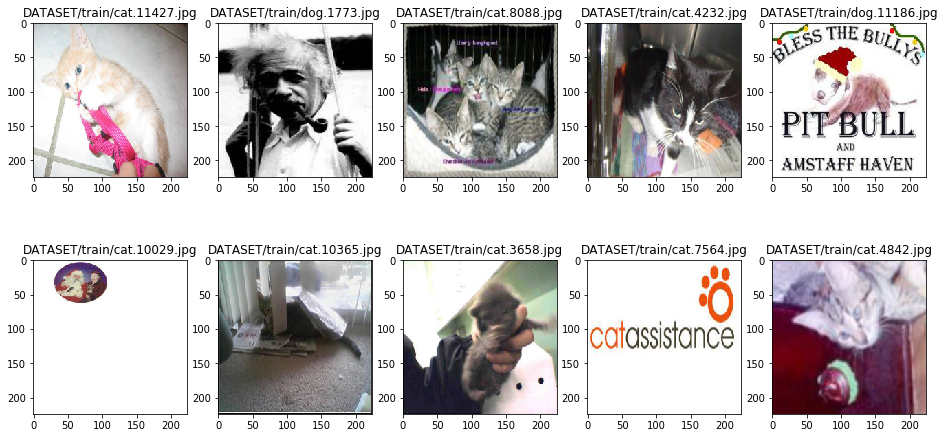

In [27]:
# 随机显示10张异常图片
except_list_sample = random.sample(except_list, 10)
display_pics(except_list_sample,pics_num=10)

In [28]:
# 将异常图片移至'DATASET/exception'文件夹，存档
if len(except_list) > 0:
    for i in except_list:
        shutil.move(i, exception_dir)


* 将清除异常图片后的训练图片集进行分类：cat和dog

In [29]:
# 生成新的file_list，并作为训练和验证的基准图片库
file_list = [train_path + "/" + i for i in get_file_names(train_path)]
test_list = [test_path + "/" + i for i in get_file_names(test_path)]
np.random.seed(1024)

cat_list = []
dog_list = []
for i in file_list:
    match_cat = re.findall(r'\bcat\.', i)
    match_dog = re.findall(r'\bdog\.', i)
    if match_cat:
        cat_list.append(i)
    elif match_dog:
        dog_list.append(i)
        
print("处理后的总图片数：{}, 其中猫的数量：{},狗的数量：{}".format(len(cat_list)+len(dog_list), len(cat_list), len(dog_list)))


处理后的总图片数：24885, 其中猫的数量：12429,狗的数量：12456


* 在DATASET/train文件夹中再建立dogs和cats文件夹，在DATASET/test中建立pics文件夹

In [30]:
# 分别建立训练集中的dog文件夹、cat文件夹和测试集文件夹pics
train_dog_dir = DATASET + "/train/dogs"
train_cat_dir = DATASET + "/train/cats"
test_pics_dir = DATASET + "/test/pics"

if not os.path.exists(train_dog_dir):
    os.makedirs(train_dog_dir)
if not os.path.exists(train_cat_dir):
    os.makedirs(train_cat_dir)
if not os.path.exists(test_pics_dir):
    os.makedirs(test_pics_dir)


* 将猫、狗数据归类到相应的cats,dogs文件夹，将test下的数据归类到pics文件夹

In [31]:
for i in cat_list:
    shutil.move(i, DATASET + "/train/cats")
for i in dog_list:
    shutil.move(i, DATASET + "/train/dogs")   
for i in test_list:
    shutil.move(i, DATASET + "/test/pics")


# 搭建模型  
---

* 建一个write_gap函数，输入:MODEL,为模型名称；img_size:图片尺寸，分两种：(299,299)和(224,224)；lambda_func:预处理函数
* 根据输入参数搭建模型并将特征向量训练结果导出

In [32]:
def write_gap(MODEL, img_size, lambda_func=None):
    img_shape = (img_size[0], img_size[1], 3)
    input_tensor = Input(img_shape)
    x = input_tensor
    
    if lambda_func:
        x = Lambda(lambda_func)(x)
    
    # 加载图片
    data_gen = ImageDataGenerator()
    X_train_gen = data_gen.flow_from_directory(train_dir, img_size, shuffle = False,batch_size = 16)
    X_test_gen = data_gen.flow_from_directory(test_dir, img_size, shuffle = False,batch_size = 16, classes = None)
    
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))
    # model.summary()
    # 训练特征向量
    train = model.predict_generator(X_train_gen, verbose = 2)
    test = model.predict_generator(X_test_gen, verbose = 2)
    
    # 保存特征向量
    with h5py.File('saved_models/weights.{}.hdf5'.format(MODEL.__name__)) as h:
        h.create_dataset('train', data = train)
        h.create_dataset('test', data = test)
        h.create_dataset('label', data = X_train_gen.classes)


* 导出特征向量：需要导出特征向量的模型：Xception，InceptionResNetV2，DenseNet201

In [33]:
# 调试专用,防止笔记本显卡显存爆掉
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [34]:
write_gap(Xception, (299,299), xception.preprocess_input)

Found 24885 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [35]:
write_gap(InceptionResNetV2, (299, 299), inception_resnet_v2.preprocess_input)

Found 24885 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [36]:
write_gap(DenseNet201, (224, 224), densenet.preprocess_input)

Found 24885 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


* 载入特征向量:  
I) 经过上面的处理，一共获得了3个特征向量文件：  
1) weights.DenseNet201.hdf5  
2) weights.InceptionResNetV2.hdf5  
3) weights.Xception.hdf5  
II) 下面是载入这些特征向量文件并将其合成一个特征向量空间

In [37]:
# 调试专用
#os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [38]:
X_train = []
X_test = []
weights_list = ["saved_models/weights.DenseNet201.hdf5", "saved_models/weights.InceptionResNetV2.hdf5", "saved_models/weights.Xception.hdf5"]
for w in weights_list:
    with h5py.File(w, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['label'])

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)

# 将X_train, y_train进行混洗，以便后续的validation_split使用，numpy的随机种子使用前面定义的
X_train, y_train = shuffle(X_train, y_train)

In [63]:
# 参数定义
epochs = 20
batch_size = 16
dropout_list = [i/100 for i in range(10,95,5)]    # 定义dropout测试列表，范围：0.1~0.9，步长0.05
optimizers.Adadelta(lr=0.1)

In [64]:
# 调节超参数dropout
def find_dropout(X_train,y_train,dropout_list):
    loss_list = []
    dropout_save_list = []
    input_tensor = Input(X_train.shape[1:])
    for i in dropout_list:
        x = Dropout(i)(input_tensor)
        x = Dense(1, activation='sigmoid')(x)
        model = Model(input_tensor, x)
        model.compile(optimizer='adadelta',loss='binary_crossentropy',metrics=['accuracy'])
        his_model = model.fit(X_train, y_train, validation_split = 0.20, epochs = epochs, batch_size = batch_size, verbose=0)
        loss_list.append(his_model.history['val_loss'][-1] if his_model.history['val_loss'][-1] <= his_model.history['loss'][-1] else 0.9)
        dropout_save_list.append(i)
    return dropout_save_list,loss_list

In [65]:
# 调用dropout调参函数
dropout_save_list,loss_list = find_dropout(X_train,y_train,dropout_list)

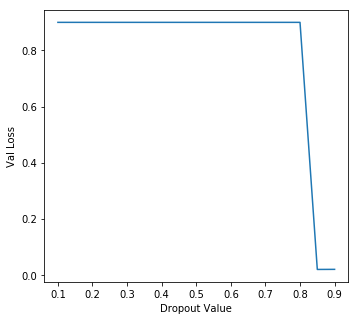

In [66]:
# 模型dropout,val_loss曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(dropout_save_list, loss_list)
# plt.legend(['val_loss'])
plt.xlabel('Dropout Value')
plt.ylabel('Val Loss')
plt.show()

* 根据调参后的参数搭建模型

In [67]:
# 求val_loss最小时的dropout值
loss_min = min(loss_list)
for i in range(len(loss_list)):
    if loss_list[i] == loss_min:
        dropout_final = dropout_save_list[i]
print(dropout_final)

0.85


In [68]:
input_tensor = Input(X_train.shape[1:])
x = Dropout(dropout_final)(input_tensor)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

* 模型概况

In [69]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 5504)              0         
_________________________________________________________________
dropout_65 (Dropout)         (None, 5504)              0         
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 5505      
Total params: 5,505
Trainable params: 5,505
Non-trainable params: 0
_________________________________________________________________


* 编译模型

In [70]:
model.compile(optimizer='adadelta',loss='binary_crossentropy',metrics=['accuracy'])

# 训练模型
---
* 训练模型并保存最佳模型参数

In [71]:
# 定义超参数
epochs = 20
batch_size = 16

# 训练模型并保存模型
checkpointer = ModelCheckpoint(filepath='saved_models/weights.final_model.hdf5',verbose=2, save_best_only=True)
his_model = model.fit(X_train, y_train, validation_split = 0.20,
                                   epochs = epochs, batch_size = batch_size, verbose=2,
                                   callbacks=[checkpointer])


Train on 19908 samples, validate on 4977 samples
Epoch 1/20
 - 24s - loss: 0.0494 - acc: 0.9837 - val_loss: 0.0184 - val_acc: 0.9944

Epoch 00001: val_loss improved from inf to 0.01843, saving model to saved_models/weights.final_model.hdf5
Epoch 2/20
 - 9s - loss: 0.0234 - acc: 0.9935 - val_loss: 0.0168 - val_acc: 0.9950

Epoch 00002: val_loss improved from 0.01843 to 0.01682, saving model to saved_models/weights.final_model.hdf5
Epoch 3/20
 - 9s - loss: 0.0226 - acc: 0.9943 - val_loss: 0.0198 - val_acc: 0.9940

Epoch 00003: val_loss did not improve from 0.01682
Epoch 4/20
 - 9s - loss: 0.0222 - acc: 0.9945 - val_loss: 0.0161 - val_acc: 0.9962

Epoch 00004: val_loss improved from 0.01682 to 0.01614, saving model to saved_models/weights.final_model.hdf5
Epoch 5/20
 - 9s - loss: 0.0225 - acc: 0.9952 - val_loss: 0.0157 - val_acc: 0.9960

Epoch 00005: val_loss improved from 0.01614 to 0.01574, saving model to saved_models/weights.final_model.hdf5
Epoch 6/20
 - 9s - loss: 0.0231 - acc: 0.99

# 可视化训练过程

* Epochs-Loss曲线

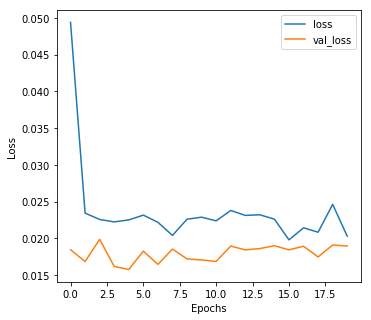

In [72]:
# 模型loss,val_loss曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(his_model.history['loss'])
plt.plot(his_model.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


* Epochs-Acc曲线

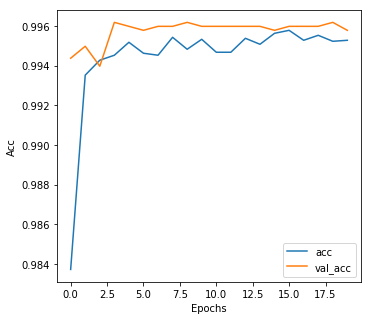

In [73]:
# 模型acc,val_acc曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(his_model.history['acc'])
plt.plot(his_model.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.show()


# 测试集预测
---

In [74]:
y_test = model.predict(X_test, verbose=1)
y_test = y_test.clip(min = 0.005, max = 0.995)


12500/12500 [==============================] - 9s 697us/step


In [75]:
data_gen = ImageDataGenerator()
X_test_gen = data_gen.flow_from_directory(test_dir, img_size, shuffle = False,batch_size = 16, classes = None)

Found 12500 images belonging to 1 classes.


In [76]:
# 保存数据到csv文件中
csv_file = submission_dir + "/sample_submission.csv"
df = pd.read_csv(csv_file)
for i, fname in enumerate(X_test_gen.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_test[i])
df.to_csv(submission_dir + '/pred_result.csv', index=None)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


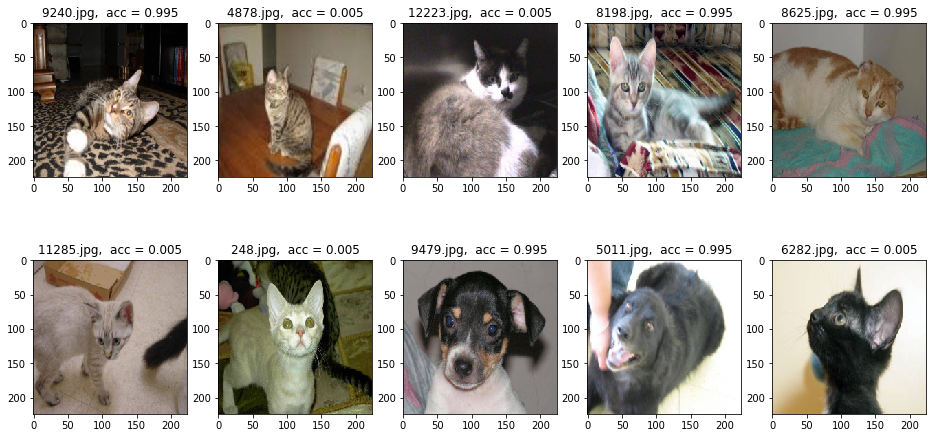

In [77]:
# 查看test中的10张图片及预测概率,0.005表示为猫，0.995表示为狗
test_list_10 = ["DATASET/test/pics/" + i for i in os.listdir("DATASET/test/pics")][:10]
display_pics(show_list=test_list_10, figsize=(16,8), pics_num=10, resize_flag=True,simple_title=True,expand_list=y_test)